In [13]:
import os
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import boto3
import awswrangler as wr
import numpy as np

In [ ]:
session = boto3.Session(profile_name='')
s3 = session.client('s3')

In [3]:
query = """
WITH 
    tipo_de_cambio_mensual AS (
        SELECT 
            DATE_TRUNC('month', fecha) AS fecha,
            AVG(tipo_de_cambio) AS tipo_de_cambio_mensual
        FROM econ.tipo_de_cambio
        GROUP BY 1
    ),

    tasa_de_interes_mensual AS (
        SELECT 
            DATE_TRUNC('month', fecha) AS fecha,
            AVG(tasa_de_interes) AS tasa_de_interes_mensual
        FROM econ.tasa_de_interes
        GROUP BY 1
    ),

    inflacion_mensual AS (
        SELECT 
            DATE_TRUNC('month', fecha) AS fecha,
            AVG(inflacion) AS inflacion_mensual
        FROM econ.inflacion
        GROUP BY 1
    )

SELECT 
    tdc.fecha,
    tdc.tipo_de_cambio_mensual,
    ti.tasa_de_interes_mensual,
    inf.inflacion_mensual
FROM tipo_de_cambio_mensual tdc
LEFT JOIN tasa_de_interes_mensual ti ON tdc.fecha = ti.fecha
LEFT JOIN inflacion_mensual inf ON tdc.fecha = inf.fecha
ORDER BY tdc.fecha;

"""

wr.athena.read_sql_query(
    query, 
    database="econ", 
    ctas_approach=False, 
    boto3_session=session
)

,fecha,tipo_de_cambio_mensual,tasa_de_interes_mensual,inflacion_mensual
0,1991-11-01,3.068377,NaN,19.720737
1,1991-12-01,3.070921,NaN,18.794623
2,1992-01-01,3.067723,NaN,17.947385
3,1992-02-01,3.062905,NaN,17.297151
4,1992-03-01,3.066768,NaN,16.824852
...,...,...,...,...
396,2024-11-01,20.345490,10.605735,4.548671
397,2024-12-01,20.266055,10.380720,4.212339
398,2025-01-01,20.549018,10.282523,3.585040
399,2025-02-01,20.457137,9.878884,3.773910


In [17]:
series = wr.athena.read_sql_query(
    
    query, 
    database="econ", 
    ctas_approach=False, 
    boto3_session=session
    
    )

series['fecha'] = pd.to_datetime(series['fecha'])
series = series.dropna()
#series = series.loc[series['fecha'] >= '2000-01-01']

In [18]:
series.head()

,fecha,tipo_de_cambio_mensual,tasa_de_interes_mensual,inflacion_mensual
40,1995-03-01,6.772159,89.482500,20.429587
41,1995-04-01,6.206383,85.220375,29.392136
42,1995-05-01,5.986071,60.446250,34.152028
43,1995-06-01,6.226882,49.500000,37.720538
44,1995-07-01,6.124990,43.000000,39.907633


### 3.1 Regresiones Líneales y scatterplots

#### 3.1.2 tipo_de_cambio ~ tasa_de_interes

RESULTADOS DE LA REGRESIÓN
                              OLS Regression Results                              
Dep. Variable:     tipo_de_cambio_mensual   R-squared:                       0.252
Model:                                OLS   Adj. R-squared:                  0.250
Method:                     Least Squares   F-statistic:                     120.6
Date:                    Sun, 16 Mar 2025   Prob (F-statistic):           2.22e-24
Time:                            23:01:45   Log-Likelihood:                -989.24
No. Observations:                     360   AIC:                             1982.
Df Residuals:                         358   BIC:                             1990.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

Text(0.5, 0, 'tasa_de_interes_mensual')

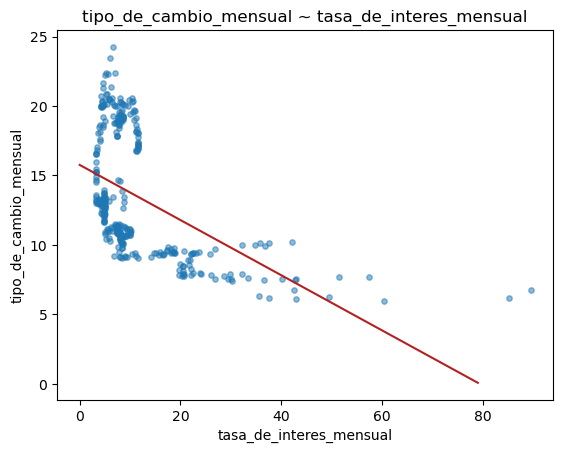

In [20]:
# Regresión
x_var = 'tasa_de_interes_mensual'
y_var = 'tipo_de_cambio_mensual'

Y = series[y_var]
X = series[x_var]
X = sm.add_constant(X)
model_1 = sm.OLS(Y,X)
results_1 = model_1.fit()
print("RESULTADOS DE LA REGRESIÓN")
print(results_1.summary())

const = results_1.params['const']
coef = results_1.params[x_var]

# Scatterplot
fig, ax = plt.subplots()
ax.scatter(X[x_var],Y, s=15, alpha = 0.5) # Scatter
ax.plot(np.arange(0,80,1), const+coef*np.arange(0,80,1), color='firebrick')

ax.set_title('{} ~ {}'.format(y_var, x_var))
ax.set_ylabel(y_var)
ax.set_xlabel(x_var)

#ax.set_xlim([0, 20])


#### 3.1.2 tasa_de_interes ~ inflacion

RESULTADOS DE LA REGRESIÓN
                               OLS Regression Results                              
Dep. Variable:     tasa_de_interes_mensual   R-squared:                       0.722
Model:                                 OLS   Adj. R-squared:                  0.722
Method:                      Least Squares   F-statistic:                     931.3
Date:                     Sun, 16 Mar 2025   Prob (F-statistic):          1.22e-101
Time:                             23:02:17   Log-Likelihood:                -1144.7
No. Observations:                      360   AIC:                             2293.
Df Residuals:                          358   BIC:                             2301.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

(0.0, 60.0)

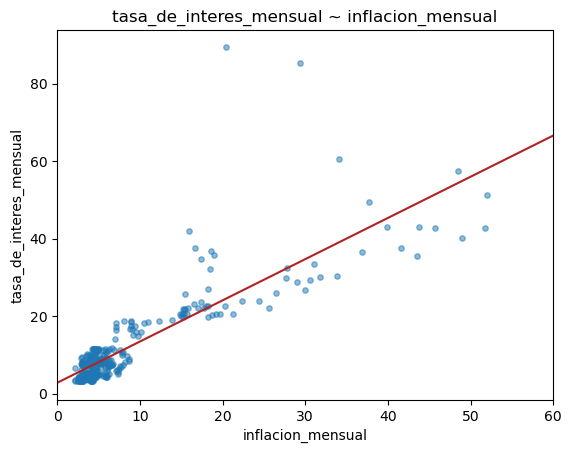

In [21]:
# Regresión
x_var = 'inflacion_mensual'
y_var = 'tasa_de_interes_mensual'

Y = series[y_var]
X = series[x_var]
X = sm.add_constant(X)
model_1 = sm.OLS(Y,X)
results_1 = model_1.fit()
print("RESULTADOS DE LA REGRESIÓN")
print(results_1.summary())

const = results_1.params['const']
coef = results_1.params[x_var]

# Scatterplot
fig, ax = plt.subplots()
ax.scatter(X[x_var],Y, s=15, alpha = 0.5) # Scatter
ax.plot(np.arange(0,80,1), const+coef*np.arange(0,80,1), color='firebrick')

ax.set_title('{} ~ {}'.format(y_var, x_var))
ax.set_ylabel(y_var)
ax.set_xlabel(x_var)
ax.set_xlim([0,60])

#### 3.1.3 tipo_de_cambio  ~ inflacion

RESULTADOS DE LA REGRESIÓN
                              OLS Regression Results                              
Dep. Variable:     tipo_de_cambio_mensual   R-squared:                       0.247
Model:                                OLS   Adj. R-squared:                  0.245
Method:                     Least Squares   F-statistic:                     117.2
Date:                    Sun, 16 Mar 2025   Prob (F-statistic):           8.15e-24
Time:                            23:02:36   Log-Likelihood:                -990.54
No. Observations:                     360   AIC:                             1985.
Df Residuals:                         358   BIC:                             1993.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

Text(0.5, 0, 'inflacion_mensual')

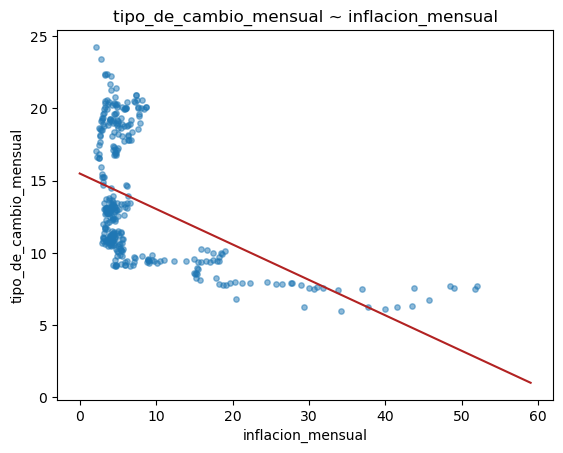

In [22]:
# Regresión
x_var = 'inflacion_mensual'
y_var = 'tipo_de_cambio_mensual'

Y = series[y_var]
X = series[x_var]
X = sm.add_constant(X)
model_1 = sm.OLS(Y,X)
results_1 = model_1.fit()
print("RESULTADOS DE LA REGRESIÓN")
print(results_1.summary())

const = results_1.params['const']
coef = results_1.params[x_var]

# Scatterplot
fig, ax = plt.subplots()
ax.scatter(X[x_var],Y, s=15, alpha = 0.5) # Scatter
ax.plot(np.arange(0,60,1), const+coef*np.arange(0,60,1), color='firebrick')

ax.set_title('{} ~ {}'.format(y_var, x_var))
ax.set_ylabel(y_var)
ax.set_xlabel(x_var)